## Homework 2

* Import Boston Dataset from sklearn dataset class.
* Explore and analyse raw data.
* Do preprocessing for regression.
* Split your dataset into train and test test (0.7 for train and 0.3 for test).
* Try Ridge and Lasso Regression models with at least 5 different alpha value for each.
* Evaluate the results of all models and choose the best performing model.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score

## LOAD AND EXPLORE THE DATASET

In [42]:
# load data
Xb,yb =load_boston(return_X_y=True)
x_boston = pd.DataFrame(Xb,columns = load_boston().feature_names)
y_boston = pd.DataFrame(yb,columns=["price"])

In [43]:
x_boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


As we can see, there are 13 features, all numeric, all non-null. We can explore them a little further with describe

In [45]:
x_boston.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.105710    8.707259  168.537116    2.164946   91.294864   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000  375.377500   
50%     77.500000    3.207450    5.000000  330.000000   19.050000  391.440000   
75%     94.075000    5.188425   24.000000  666.000000   20.200000  396.225000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            LSTAT  
count  506.000000  
mean    12.653063  
std      7.141062  
min      1.730000  
25%      6.950000  
50%     11.360000  
75%     16.955000  
max     37.970000

The variables ranges are quite different, so it will be better to normalize them before training the model. Let's investigate possible outliers and duplicates.

In [46]:
# duplicates
duplicates = x_boston.duplicated(subset=None, keep='first')
duplicates.sum()

0

In [47]:
# outliers
z = np.abs(stats.zscore(x_boston))
outliers = list(set(np.where(z > 3)[0]))
len(outliers)

91

There are 58 records that can be considered outliers, I will elliminate them from the dataset

In [48]:
clean = pd.concat([x_boston,y_boston], axis=1)
clean2 = clean.drop(outliers,axis = 0).reset_index(drop = True)
len(clean2)

415

In [49]:
x_boston = clean2.drop(['price'], axis=1)
y_boston = clean2['price']
print(len(x_boston))
print(len(y_boston))

415
415


In [50]:
print(list(x_boston))

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


Let's investigate correlation among features

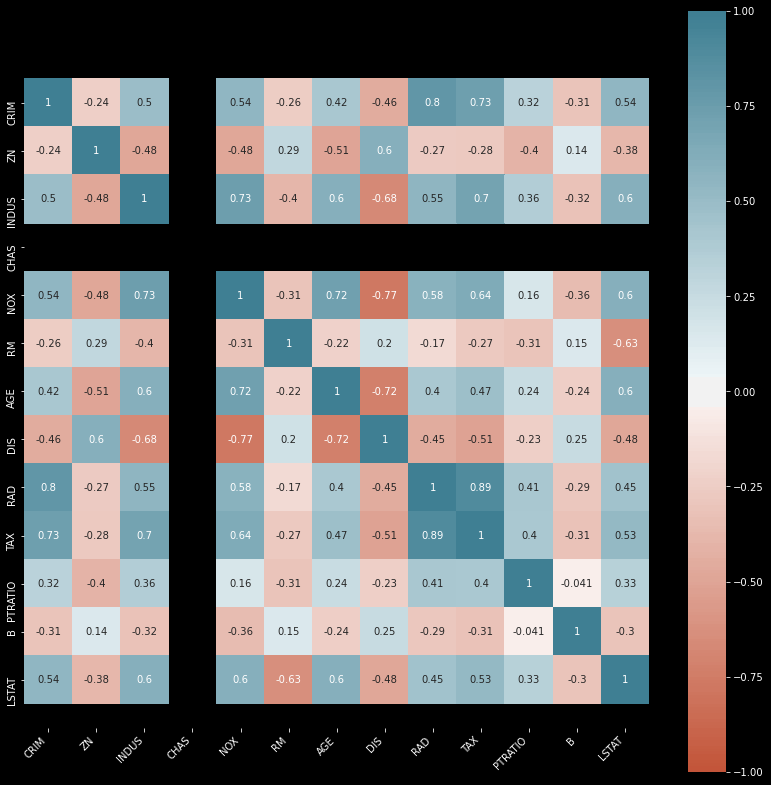

In [51]:
corr = x_boston.corr()

plt.figure(figsize=(14, 14))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_ylim(len(corr)+0.5, -0.5);

Removing outliers made the feature CHAS disapear. Also, for all pair of features with correlation larger than 0.7 in absolute terms, I will drop one of them. 

From the table above, candidates to be dropped are the pairs:

* AGE - DIS
* RAD - TAX
* INDUS - NOX
* DIS - INDUS
* AGE - NOX
* DIS - NOX

AGE - DIS - INDUS - NOX  seem to be all correlated and will be investigated together

In [52]:
test1 = pd.concat([x_boston['AGE'],x_boston['DIS'],x_boston['INDUS'],x_boston['NOX'],y_boston],axis=1)

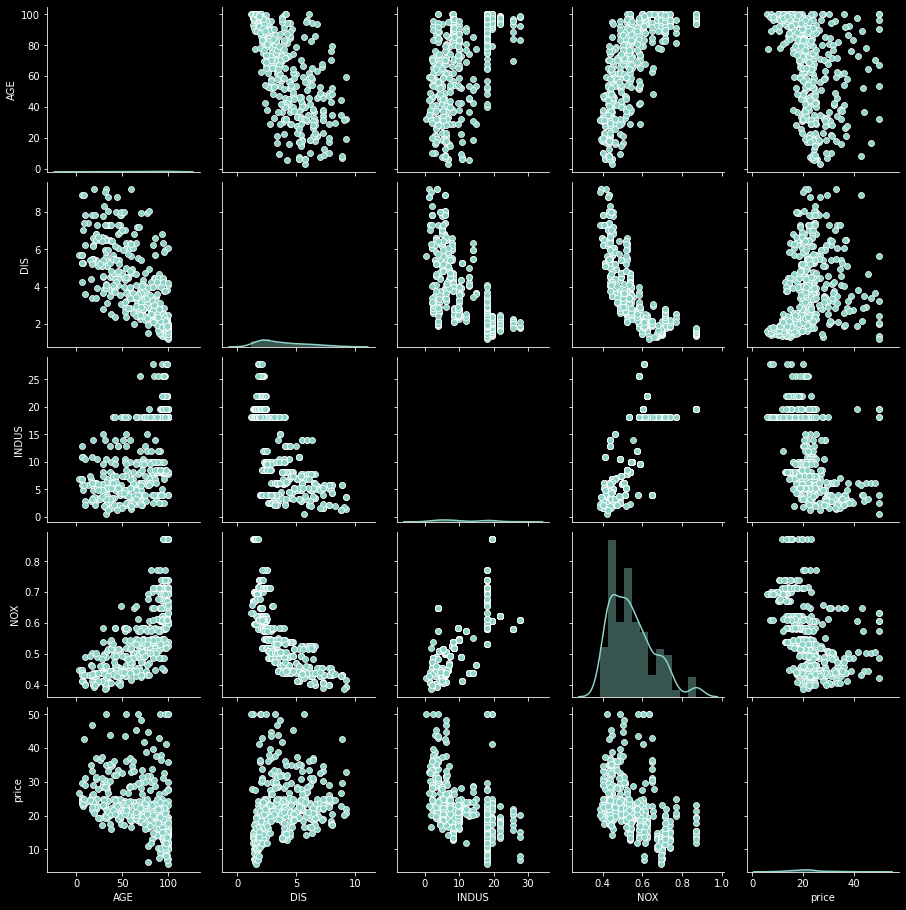

In [53]:
g = sns.PairGrid(test1)
g.map_diag(sns.distplot)
g.map_offdiag(sns.scatterplot)

Looking at the plot above, it doesn´t seem that any of the variables are very correlated with our label variable (y_boston). If anything DIS seems to be the best one, so I will keep it and drop the rest

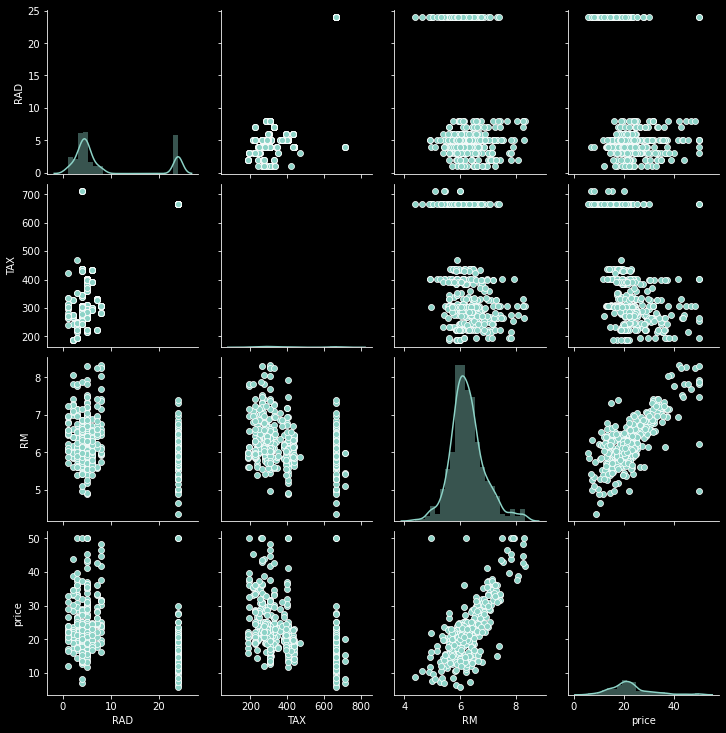

In [54]:
test2 = pd.concat([x_boston['RAD'],x_boston['TAX'],x_boston['RM'],y_boston],axis=1)
g = sns.PairGrid(test2)
g.map_diag(sns.distplot)
g.map_offdiag(sns.scatterplot)

From the graph above, seems that RM is the only feature worth including, so I will drop the rest.

In [55]:
drop_col = ('AGE','INDUS','NOX','RAD','TAX','CHAS')
for col in drop_col:
    x_boston = x_boston.drop(col,axis=1)
x_boston.head()

CRIM    ZN     RM     DIS  PTRATIO       B  LSTAT
0  0.00632  18.0  6.575  4.0900     15.3  396.90   4.98
1  0.02731   0.0  6.421  4.9671     17.8  396.90   9.14
2  0.02729   0.0  7.185  4.9671     17.8  392.83   4.03
3  0.03237   0.0  6.998  6.0622     18.7  394.63   2.94
4  0.06905   0.0  7.147  6.0622     18.7  396.90   5.33

Let's have a look at the dataset at this point

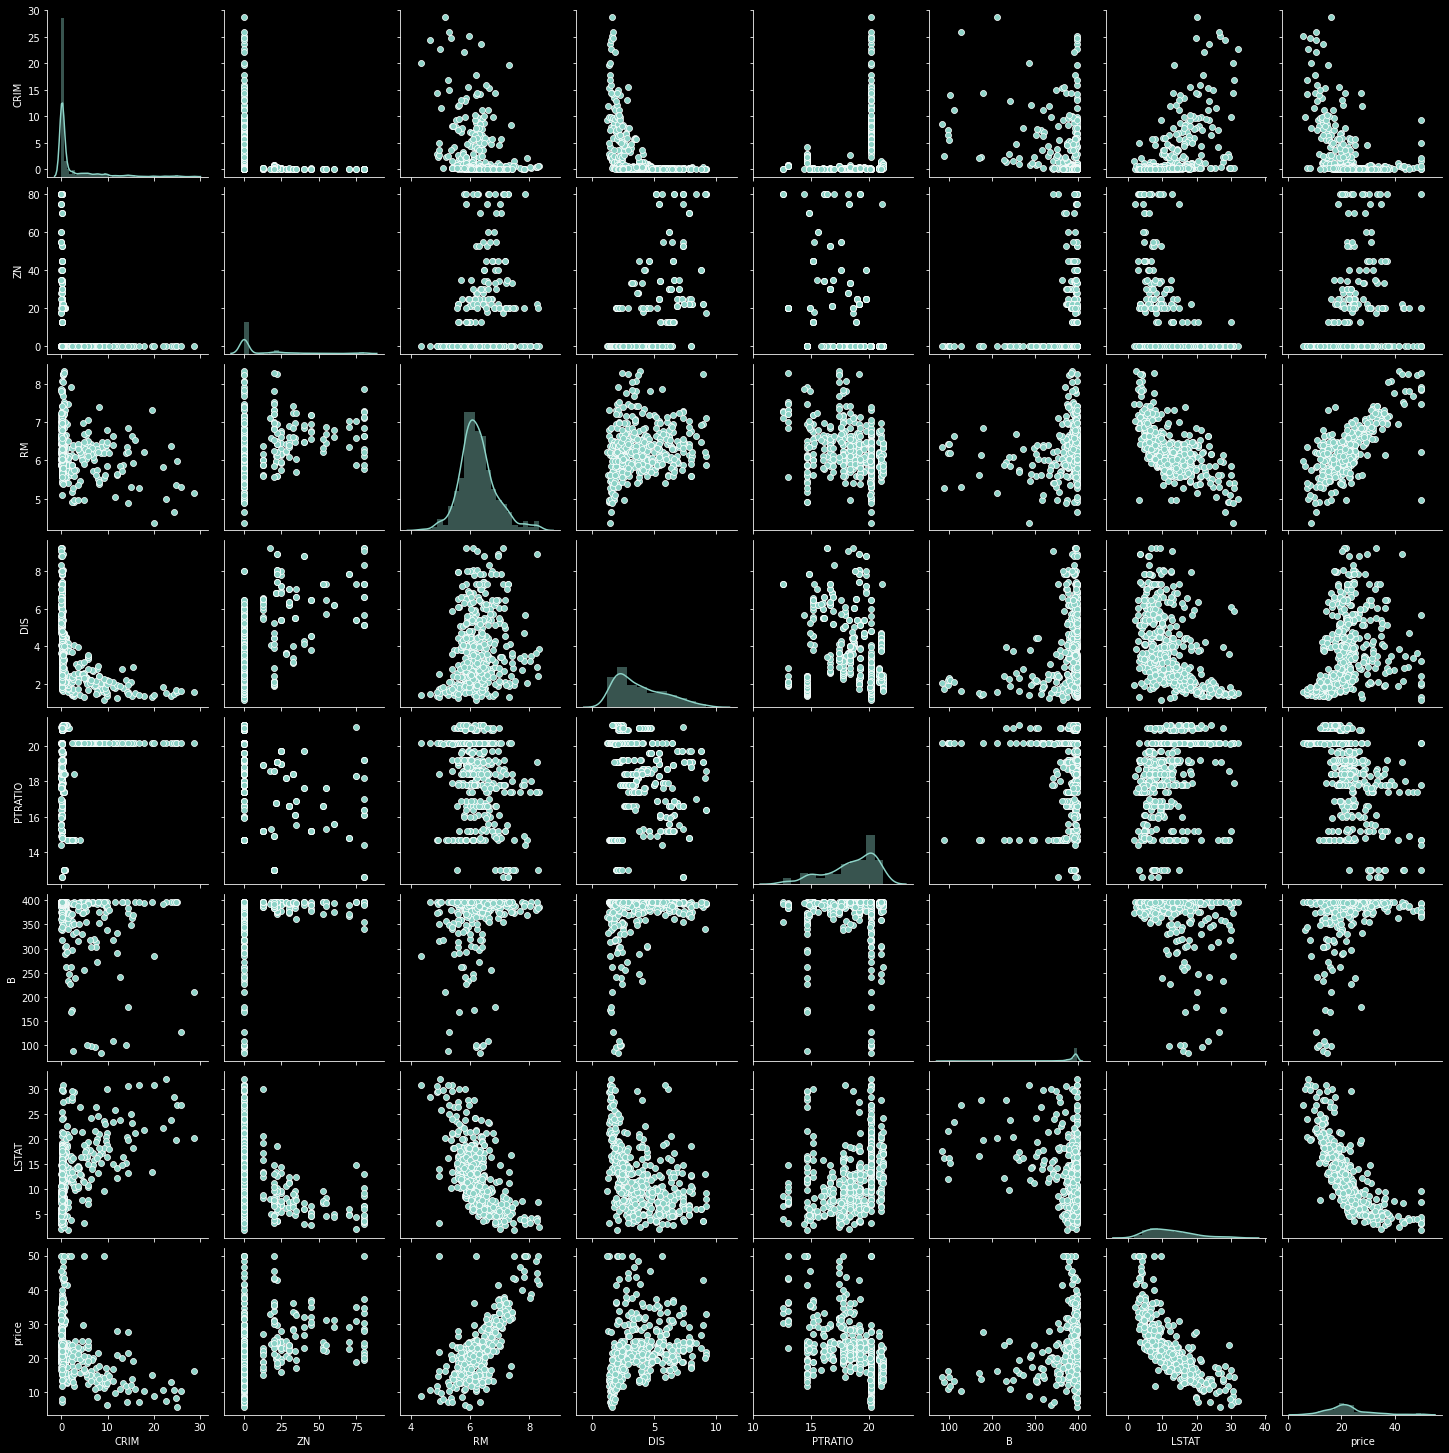

In [56]:
test3 = pd.concat([x_boston,y_boston],axis=1)
g = sns.PairGrid(test3)
g.map_diag(sns.distplot)
g.map_offdiag(sns.scatterplot)

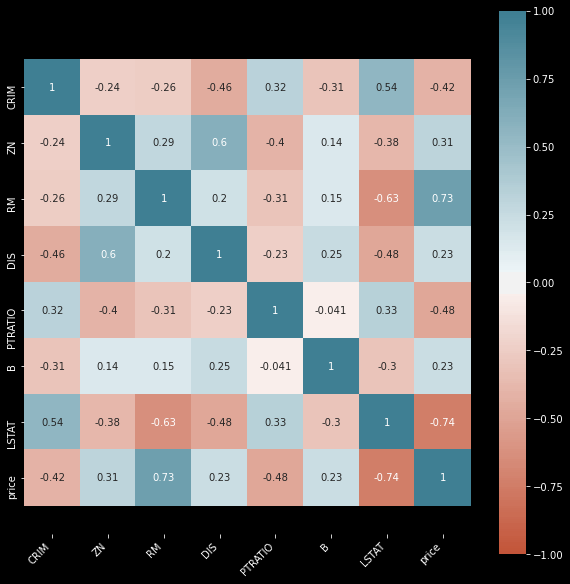

In [57]:
corr = test3.corr()

plt.figure(figsize=(10, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_ylim(len(corr)+0.5, -0.5);

This seems to be an appropriate set of features to begin the modeling process. 
The next stage is normalization.

In [58]:
# get column names
col_names = list(x_boston)

In [59]:
# scale features
scaler = preprocessing.MinMaxScaler().fit(x_boston)
x_scaled = pd.DataFrame(scaler.transform(x_boston),columns = col_names)
x_scaled.head()

CRIM     ZN        RM       DIS   PTRATIO         B     LSTAT
0  0.000000  0.225  0.556059  0.362674  0.313953  1.000000  0.107403
1  0.000733  0.000  0.517259  0.471579  0.604651  1.000000  0.244878
2  0.000732  0.000  0.709751  0.471579  0.604651  0.987015  0.076008
3  0.000909  0.000  0.662635  0.607552  0.709302  0.992758  0.039987
4  0.002190  0.000  0.700176  0.607552  0.709302  1.000000  0.118969

## REGRESSION MODEL

In [60]:
# split data in train and validation
x_train,x_test,y_train,y_test = train_test_split(x_scaled,y_boston,random_state=0,test_size=0.3)

In [61]:
# instanciate and fit the model
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [62]:
# Function to calculate adjusted R-square
def adj_r2 (X,y,model):
    r_squared = model.score(X,y)
    return(1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1))

In [63]:
# get R-squared and adjusted R-squared
print("R-squared train = ", model.score(x_train,y_train))
print("R-squared test = ", model.score(x_test,y_test))
print("Adj-R-squared train = ", adj_r2(x_train,y_train,model))
print("Adj-R-squared test = ", adj_r2(x_test,y_test,model))

R-squared train =  0.7396439376028825
R-squared test =  0.6628852536436228
Adj-R-squared train =  0.7331811984653653
Adj-R-squared test =  0.6427159953146089


In [65]:
# Print coefficients importance
importance = model.coef_
for i in range(7):
    print("Feature", x_scaled.columns[i], "Score:", importance[i])


Feature CRIM Score: -2.7913873241042233
Feature ZN Score: 0.5060671238636053
Feature RM Score: 18.695768797748674
Feature DIS Score: -5.235059318717422
Feature PTRATIO Score: -7.298551976692235
Feature B Score: 2.8059460690498255
Feature LSTAT Score: -17.319940750191677


As we can see, there is some difference between train and test R-squared which is usually sign of overfitting. I will try with ridge and lasso regresions to avoid it, although I do not expect a lot of improvement, since all coefficients are roughly within the same range. Another alternative would be reducing the model´s complexity but it is not clear to me at this point which feature to drop.

In [66]:
# Dropping the least correlated feature
x_scaled2 = x_scaled.drop(['ZN'], axis=1)
x_train2,x_test2,y_train2,y_test2 = train_test_split(x_scaled2,y_boston,random_state=0,test_size=0.3)
model2 = LinearRegression()
model2.fit(x_train2,y_train2)
print("R-squared train = ", model2.score(x_train2,y_train2))
print("R-squared test = ", model2.score(x_test2,y_test2))

R-squared train =  0.7395271289347651
R-squared test =  0.6631343221544443


As shown above, reducing model complexity doesn´t substantially change the generalization problem. Thus, I will not reduce the number of features.

## RIDGE REGRESSION

In [71]:
ridge_model = Ridge(alpha = 0.01)
ridge_model.fit(x_train, y_train)
print("Ridge Train: ", ridge_model.score(x_train, y_train))
print("Ridge Test: ", ridge_model.score(x_test, y_test))

Ridge Train:  0.7396436573755958
Ridge Test:  0.6628145985304468


In [72]:
ridge_model = Ridge(alpha = 0.001)
ridge_model.fit(x_train, y_train)
print("Ridge Train: ", ridge_model.score(x_train, y_train))
print("Ridge Test: ", ridge_model.score(x_test, y_test))

Ridge Train:  0.7396439375748024
Ridge Test:  0.6628845486251951


In [73]:
ridge_model = Ridge(alpha = 0.0001)
ridge_model.fit(x_train, y_train)
print("Ridge Train: ", ridge_model.score(x_train, y_train))
print("Ridge Test: ", ridge_model.score(x_test, y_test))

Ridge Train:  0.7396439375748024
Ridge Test:  0.6628845486251951


In [74]:
ridge_model = Ridge(alpha = 0.00001)
ridge_model.fit(x_train, y_train)
print("Ridge Train: ", ridge_model.score(x_train, y_train))
print("Ridge Test: ", ridge_model.score(x_test, y_test))

Ridge Train:  0.7396439376026017
Ridge Test:  0.6628851831431759


In [75]:
ridge_model = Ridge(alpha = 0.000001)
ridge_model.fit(x_train, y_train)
print("Ridge Train: ", ridge_model.score(x_train, y_train))
print("Ridge Test: ", ridge_model.score(x_test, y_test))

Ridge Train:  0.7396439376028796
Ridge Test:  0.6628852465935919


In [78]:
ridge_model = Ridge(alpha = 0)
ridge_model.fit(x_train, y_train)
print("Ridge Train: ", ridge_model.score(x_train, y_train))
print("Ridge Test: ", ridge_model.score(x_test, y_test))

Ridge Train:  0.7396439376028825
Ridge Test:  0.6628852536436227


## LASSO REGRESSION

In [80]:
lasso_model = Lasso(alpha = 0.01)
lasso_model.fit(x_train, y_train)
print("Lasso Train: ", lasso_model.score(x_train, y_train))
print("Lasso Test: ", lasso_model.score(x_test, y_test))

Lasso Train:  0.7393532445846895
Lasso Test:  0.6625211516638827


In [79]:
lasso_model = Lasso(alpha = 0.001)
lasso_model.fit(x_train, y_train)
print("Lasso Train: ", lasso_model.score(x_train, y_train))
print("Lasso Test: ", lasso_model.score(x_test, y_test))

Lasso Train:  0.7396411715211924
Lasso Test:  0.6628784570862672


In [81]:
lasso_model = Lasso(alpha = 0.0001)
lasso_model.fit(x_train, y_train)
print("Lasso Train: ", lasso_model.score(x_train, y_train))
print("Lasso Test: ", lasso_model.score(x_test, y_test))

Lasso Train:  0.7396439081956732
Lasso Test:  0.6628854578851903


In [82]:
lasso_model = Lasso(alpha = 0.00001)
lasso_model.fit(x_train, y_train)
print("Lasso Train: ", lasso_model.score(x_train, y_train))
print("Lasso Test: ", lasso_model.score(x_test, y_test))

Lasso Train:  0.7396439373090924
Lasso Test:  0.6628852204560074


In [83]:
lasso_model = Lasso(alpha = 0.000001)
lasso_model.fit(x_train, y_train)
print("Lasso Train: ", lasso_model.score(x_train, y_train))
print("Lasso Test: ", lasso_model.score(x_test, y_test))

Lasso Train:  0.7396439375999825
Lasso Test:  0.662885247707166


In [84]:
lasso_model = Lasso(alpha = 0)
lasso_model.fit(x_train, y_train)
print("Lasso Train: ", lasso_model.score(x_train, y_train))
print("Lasso Test: ", lasso_model.score(x_test, y_test))

Lasso Train:  0.7396439376028825
Lasso Test:  0.6628852536436228


In [ ]:
## BEST MODEL

The best model (not for much) is the Lasso with alph = 0.0001, with scores of:

* R-square Train:  0.7396439081956732
* R-square Test:  0.6628854578851903